<a href="https://colab.research.google.com/github/girinath18/stable_diffusion/blob/main/Updated%20text%20to%20image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --upgrade diffusers transformers accelerate invisible_watermark mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.2 MB/s eta 0:00:00


In [2]:
!pip install --upgrade diffusers


In [3]:
use_refiner = False
use_latent_consistency = True

In [4]:
import mediapy as media
import random
import sys
import torch

from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

# Pick:
# -    2, 4 or 8 steps for lora,
# - 1, 2, 4 or 8 steps for unet.
num_inference_steps = 4

# Prefer "unet" over "lora" for quality.
use_lora = False
model_type = "lora" if use_lora else "unet"

base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = f"sdxl_lightning_{num_inference_steps}step_{model_type}.safetensors"
device = "cuda"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
unet = UNet2DConditionModel.from_config(
    base,
    subfolder="unet",
    ).to(device, torch.float16)

unet.load_state_dict(
    load_file(
        hf_hub_download(
            repo,
            ckpt,
            ),
        device=device,
        ),
    )

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all o

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

sdxl_lightning_4step_unet.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

<All keys matched successfully>

In [6]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    base,
    unet=unet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    ).to(device)

if use_lora:
  pipe.load_lora_weights(hf_hub_download(repo, ckpt))
  pipe.fuse_lora()

pipe.scheduler = EulerDiscreteScheduler.from_config(
    pipe.scheduler.config,
    timestep_spacing="trailing",
    )


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:	A beautiful woman in the beach , realistic, perfect formation , high resolution
Seed:	9180914215240817105


""

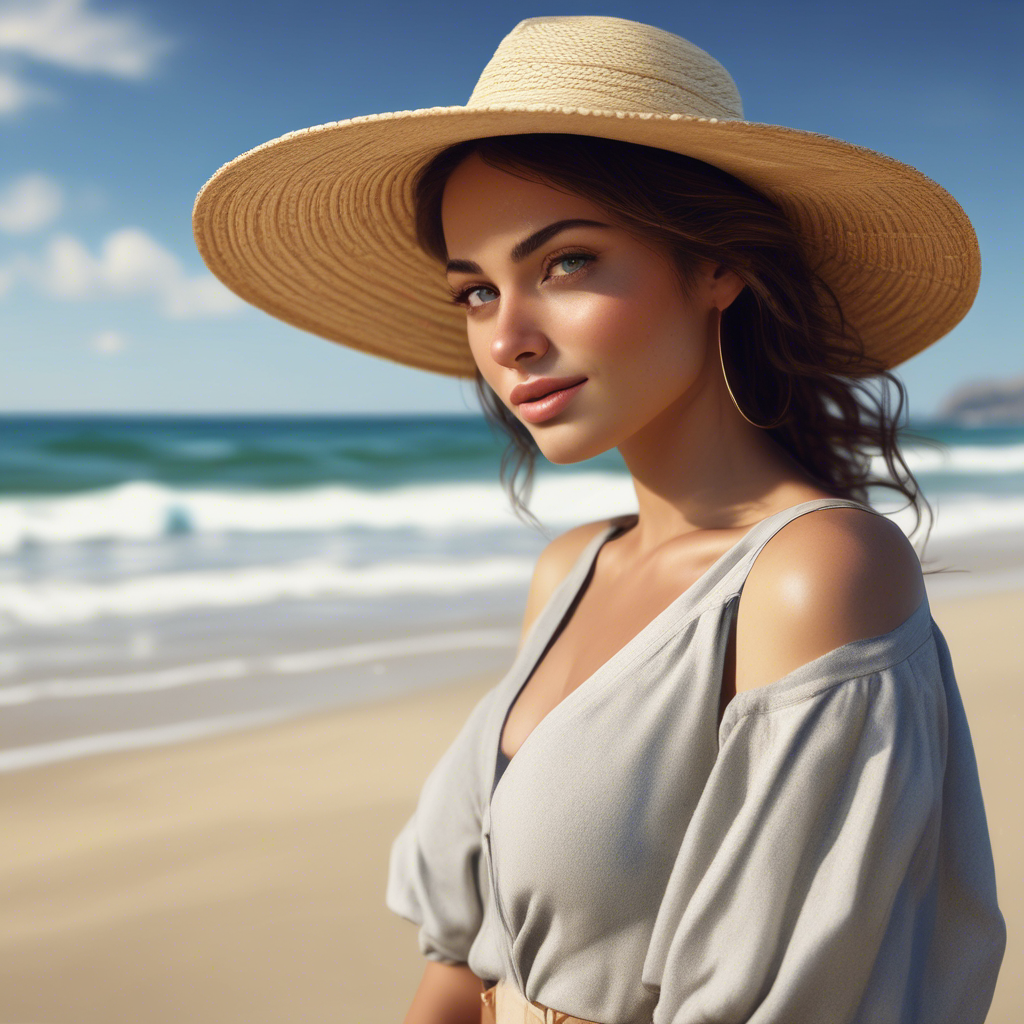

In [12]:
prompt = "A beautiful woman in the beach , realistic, perfect formation , high resolution"
seed = random.randint(0, sys.maxsize)

images = pipe(
    prompt = prompt,
    guidance_scale = 0.0,
    num_inference_steps = num_inference_steps,
    generator = torch.Generator("cuda").manual_seed(seed),
    ).images

print(f"Prompt:\t{prompt}\nSeed:\t{seed}")
media.show_images(images)
images[0].save("output.jpg")